This notebook is to test if the native zfit CB function works the way we expect by making our own CB and seeing if there are differences

In [1]:
import tensorflow as tf
import zfit
import matplotlib.pyplot as plt
import numpy as np
import zfit.z.numpy as znp

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


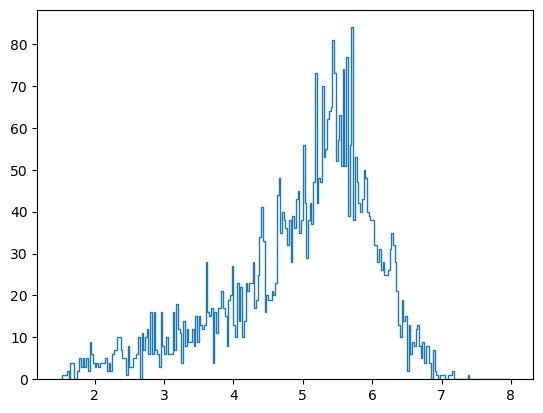

In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec867_TTREE.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"]) #importing data from root file
energy_unbinned = data["spec"] #crystal spec is the raw energy values
bin_count = 260 #trivially set depending on what we want the y axis to represent (x evts/kev)
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8)) #binning energy values and creating an x array of bin location
bin_centers =  (bin_location[1:] + bin_location[:-1])/2
cryspec = zfit.Space(['x'], limits=(1.5,8)) #obs range
lower, upper = cryspec.limits
x_range= cryspec.area() 
scale = (len(energy_unbinned)/bin_count)*x_range #the pdfs are normalised to =1 so must apply scaling factor

#### Native Zfit CB

In [3]:
#extended fit
ergElec = 0.511 
A = zfit.Parameter ("A constant", 0.0169, 0.0149, 0.0189);
B = zfit.Parameter ("B constant", 0.01, 0.005, 0.04);
fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0); #alpha
fcbndeg = zfit.Parameter ("fcbndeg", 10); #n degrees ## remove upper limiits
fullPeak = zfit.Parameter( "full peak", 6, 5.6, 6.2); 
fullRes = np.sqrt(pow(A/pow((fullPeak/1000),0.25),2)) + (B)**2 + (0.15/fullPeak)**2 #fractional resolution
fullWidth = zfit.Parameter( "width of the full peak", 0.4); 
EvnFull = zfit.Parameter("No. of Events in full peak", 400);
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnFull)
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)

#unextended fit
A_unext = zfit.Parameter ("A constant for unextended fit", 0.03, 0.0149, 0.05);
B_unext = zfit.Parameter ("B constant for unextended fit", 0.03, 0.005, 0.04);
fcbalpha_unext = zfit.Parameter("fcbalpha for unextended fit", 2.5, 0.05, 20.0); #alpha
fcbndeg_unext = zfit.Parameter ("fcbndeg for unextended fit", 10); #n degrees
fullPeak_unext = zfit.Parameter( "full peak for unextended fit", 6, 5.6, 6.2); 
fullRes_unext = np.sqrt(pow(A_unext/pow((fullPeak_unext/1000),0.25),2)) + (B_unext)**2 + (0.15/fullPeak_unext)**2 #fractional resolution
#fullRes_unext = np.sqrt(pow(A/pow((fullPeak/1000),0.25),2)) + (B)**2 + (0.15/fullPeak)**2 #fractional resolution
#fullWidth_unext = zfit.Parameter( "width of the full peak for unextended fit",fullPeak*fullRes ); \
#fullWidth_unext = zfit.Parameter( "width of the full peak for unextended fit",fullPeak_unext*fullRes_unext ); 
fullWidth_unext = zfit.Parameter( "width of the full peak for unextended fit", 0.4 ); \

fullErg_unext = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak_unext, sigma=fullWidth_unext, alpha=fcbalpha_unext, n=fcbndeg_unext)
#fullErg_unext = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg)

y_plot_full_unext = fullErg_unext.pdf(bin_centers,norm_range=cryspec)

#### Hand-made Crystal Ball func

In [4]:
from zfit.core.basepdf import BasePDF
from zfit.core.serialmixin import SerializableMixin
from zfit.util import ztyping
from zfit.util.ztyping import ExtendedInputType, NormInputType
from zfit.core.space import ANY_LOWER, ANY_UPPER, Space, supports


A_const = zfit.Parameter ("A constant for created fit", 0.0169, 0.0149, 0.0189);
B_const = zfit.Parameter ("B constant for created fit", 0.01, 0.005, 0.04);
alpha = zfit.Parameter("alpha", 2.5, 0.05, 20.0);
n = zfit.Parameter ("n", 10);
mu = zfit.Parameter( "mu", 6, 5.6, 6.2);
fracRes = np.sqrt(pow(A_const/pow((mu/1000),0.25),2)) + (B_const)**2 + (0.15/mu)**2 #fractional resolution
#fracRes = np.sqrt(pow(A/pow((mu/1000),0.25),2)) + (B)**2 + (0.15/mu)**2 #fractional resolution
sigma=zfit.Parameter("sigma of the full peak", 0.4)
#sigma = zfit.Parameter( "sigma",mu*fracRes);
fraction = zfit.Parameter("Fraction of peak", 400);


In [5]:
def _powerlaw(x, a, k):
    return a * znp.power(x, k)


class zfitCB(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['alpha', 'n' ,'mu', 'sigma']


    def _unnormalized_pdf(self,x):
        x = zfit.z.unstack_x(x)
        alpha = self.params['alpha']
        n = self.params['n']
        mu = self.params['mu']
        sigma = self.params['sigma']
        t = (x - mu) / sigma * tf.sign(alpha)
        abs_alpha = znp.abs(alpha)
        a = znp.power((n / abs_alpha), n) * znp.exp(-0.5 * znp.square(alpha))
        b = (n / abs_alpha) - abs_alpha
        cond = tf.less(t, -abs_alpha)
        func = zfit.z.zextension.safe_where(
            cond,
            lambda t: _powerlaw(b - t, a, -n),
            lambda t: znp.exp(-0.5 * znp.square(t)),
            values=t,
            value_safer=lambda t: znp.ones_like(t) * (b - 2),
            )
        return znp.maximum(func, znp.zeros_like(func))

#@zfit.function(wraps="tensor", keepalive=True)
CBfunc = zfitCB(obs=cryspec,mu=mu,alpha=alpha,n=n,sigma=sigma)
y_plot_CB = CBfunc.pdf(bin_centers,norm_range=cryspec)
#def crystalball_func(x, mu, sigma, alpha, n):
#    t = (x - mu) / sigma * tf.sign(alpha)
#    abs_alpha = znp.abs(alpha)
#    a = znp.power((n / abs_alpha), n) * znp.exp(-0.5 * znp.square(alpha))
#    b = (n / abs_alpha) - abs_alpha
#    cond = tf.less(t, -abs_alpha)
#    func = zfit.z.safe_where(
#        cond,
#        lambda t: _powerlaw(b - t, a, -n),
#        lambda t: znp.exp(-0.5 * znp.square(t)),
#        values=t,
#        value_safer=lambda t: znp.ones_like(t) * (b - 2),
#    )
#    return znp.maximum(func, znp.zeros_like(func))
#
#class CrystalBall(BasePDF, SerializableMixin):
#    _N_OBS = 1
#
#    def __init__(
#        self,
#        mu: ztyping.ParamTypeInput,
#        sigma: ztyping.ParamTypeInput,
#        alpha: ztyping.ParamTypeInput,
#        n: ztyping.ParamTypeInput,
#        obs: ztyping.ObsTypeInput,
#        *,
#        extended: ExtendedInputType = None,
#        norm: NormInputType = None,
#        name: str = "CrystalBall",
#        label: str | None = None,
#    ):
#        params = {"mu": mu, "sigma": sigma, "alpha": alpha, "n": n}
#        super().__init__(obs=obs, name=name, params=params, extended=extended, norm=norm, label=label)
#
#    @supports(norm=False)
#    def _pdf(self, x, norm, params):
#        del norm
#        mu = params["mu"]
#        sigma = params["sigma"]
#        alpha = params["alpha"]
#        n = params["n"]
#        x = zfit.z.unstack_x(x)
#        return crystalball_func(x=x, mu=mu, sigma=sigma, alpha=alpha, n=n)
#
#CBfunc = CrystalBall(obs=cryspec,mu=mu,alpha=alpha,n=n,sigma=sigma,extended=fraction)
#y_plot_CB = CBfunc.pdf(bin_centers,norm_range=cryspec)

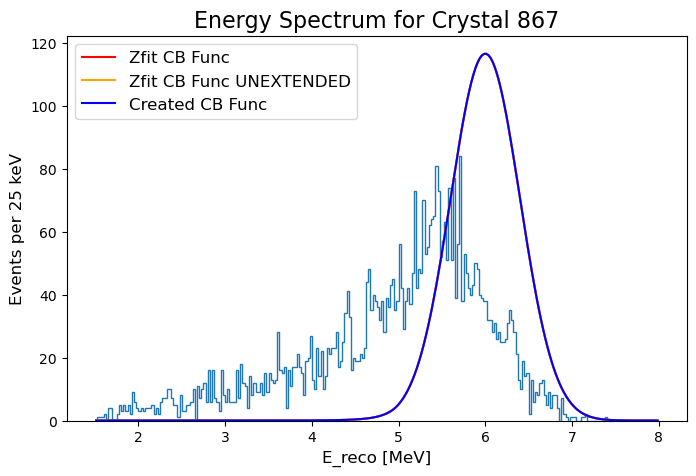

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale, color="red", label='Zfit CB Func')
plt.plot(bin_centers, y_plot_full_unext*scale, color="orange", label='Zfit CB Func UNEXTENDED')
plt.plot(bin_centers, y_plot_CB*scale, color="blue",label='Created CB Func')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);

In [7]:
integral_before =  CBfunc.integrate(limits=(lower,upper))
integral_before

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.])>

In [9]:
nll_native = zfit.loss.ExtendedUnbinnedNLL(model=fullErg, data=energy_unbinned)
nll_native_unext = zfit.loss.UnbinnedNLL(model=fullErg_unext, data=energy_unbinned)
nll_manual = zfit.loss.UnbinnedNLL(model=CBfunc, data=energy_unbinned) #currently this is not extended 
#nll_manual_combined = zfit.loss.UnbinnedNLL(model=combinedCB, data=energy_unbinned) #currently this is not extended 

minimizer = zfit.minimize.Minuit()

result_1 = minimizer.minimize(nll_native, params=[A, B, fcbalpha,fcbndeg,fullPeak,EvnFull,fullWidth]) #add fraction
result_1_unext = minimizer.minimize(nll_native_unext, params=[A_unext,B_unext,fcbalpha_unext,fcbndeg_unext,fullPeak_unext,fullWidth_unext])
result_2 = minimizer.minimize(nll_manual, params=[A_const,B_const,alpha,n,mu,sigma,fraction])

param_hesse = result_1.hesse()
param_hesse1_unext = result_1_unext.hesse()
param_hesse2 = result_2.hesse()

print(result_1)
print("number of events",len(energy_unbinned))
print(result_1_unext)
print(result_2)

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1393: RuntimeWarning: minuit failed to calculate the covariance matrix or similar when calling `hesse`.Try to use `hesse_np` as the method instead and try again.This is unexpected and may has to do with iminuitV2. Either way, please fill an issue if this is not expected to fail for you.
  return method(result=self, params=params)


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.physics.CrystalBall'>  params=[fcbalpha, fcbndeg, full peak, width of the full peak]] data=[<zfit.Data: Data obs=('x',) shape=(4681, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 1.3e-11 │        -28439.36 |  10008.21 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                          value  (rounded)    at limit
--------------------------  ------------------  ----------
A constant                              0.0169       False
B constant                                0.01       False
fcbalpha                              0.403229       False
fcbndeg  

In [10]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_full_unext = fullErg_unext.pdf(bin_centers,norm_range=cryspec)
y_plot_CB = CBfunc.pdf(bin_centers)
#y_plot_CB1 = CBfunc1.pdf(bin_centers)
#y_plot_combined = combinedCB.pdf(bin_centers,norm_range=cryspec)


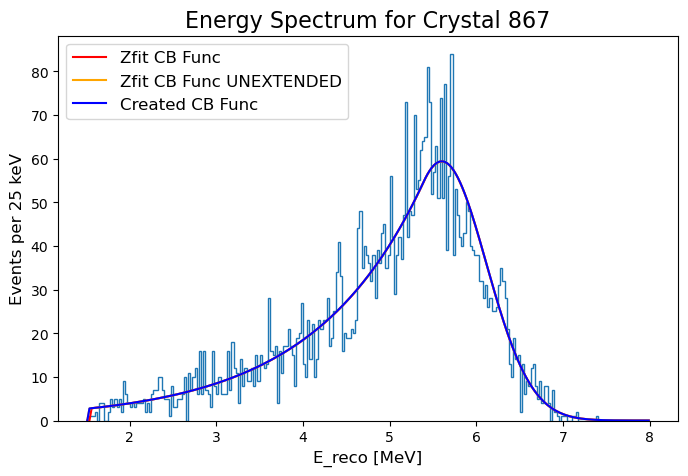

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(1.5,8))

plt.plot(bin_centers, y_plot_full*scale, color="red", label='Zfit CB Func')
plt.plot(bin_centers, y_plot_full_unext*scale, color="orange", label='Zfit CB Func UNEXTENDED')
plt.plot(bin_centers, y_plot_CB*scale, color="blue",label='Created CB Func')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);

In [ ]:
integral_CB = CBfunc.integrate(limits=(lower,upper))

integral_ext = CBfunc.integrate(limits=(lower,upper))

integral_unext = CBfunc.integrate(limits=(lower,upper))
print('Integral of created CB',integral_CB)
print('Integral of extended zfit pdf',integral_ext)
print('Integral of unextended zfit pdf',integral_unext)

#### Adding another PDF